In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
![image.png](attachment:image.png)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

# Importing the necessary libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) # Specify dtype=object to handle inconsistent shapes


# Loading the Dataset

In [5]:
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization & Preprocessing

<Axes: xlabel='count'>

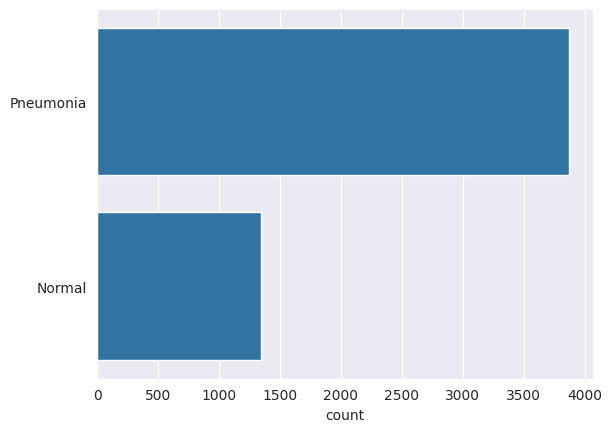

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

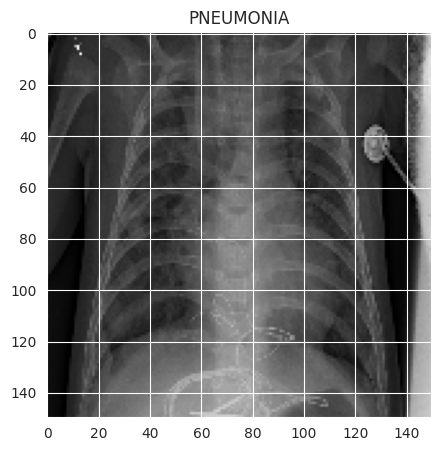

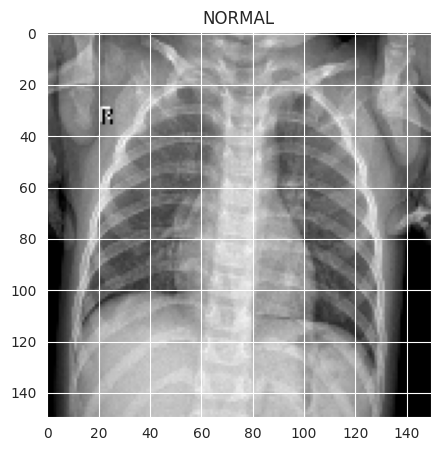

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [9]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [13]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    if gpus:
        device = '/GPU:0'
    else:
        device = '/CPU:0'
print("Using device:", device)

NameError: name 'torch' is not defined

## CNN

In [14]:
import glob
import os
import random
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

warnings.filterwarnings('ignore')

In [15]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10
num_classes = 1

In [21]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout

def create_cnn_classifier():

    model = Sequential([
        Conv2D(32, 3, activation='relu', input_shape=(150,150,1),
              kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, 3, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    return model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ]
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        epochs=50,                                  # train longer, but early-stop
        validation_data=datagen.flow(x_val, y_val),
        callbacks=callbacks
    )

    return history

cnn_classifier = create_cnn_classifier()
history_cnn = run_experiment(cnn_classifier)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7377 - auc: 0.8668 - loss: 0.6766 - val_accuracy: 0.5000 - val_auc: 0.5547 - val_loss: 1.0262 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.8463 - auc: 0.9376 - loss: 0.4510 - val_accuracy: 0.5000 - val_auc: 0.6484 - val_loss: 0.8869 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8786 - auc: 0.9490 - loss: 0.3903 - val_accuracy: 0.5000 - val_auc: 0.6250 - val_loss: 1.0695 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8739 - auc: 0.9512 - loss: 0.3608 - val_accuracy: 0.5000 - val_auc: 0.5469 - val_loss: 1.2638 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8925 - auc: 0.9507 - loss: 0.3412 - val_accuracy: 0.5625 - val_auc: 0.6953 - val_loss: 0.8959 - learning_rate: 5.0000e-05
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/s

### Analysis after Model Training

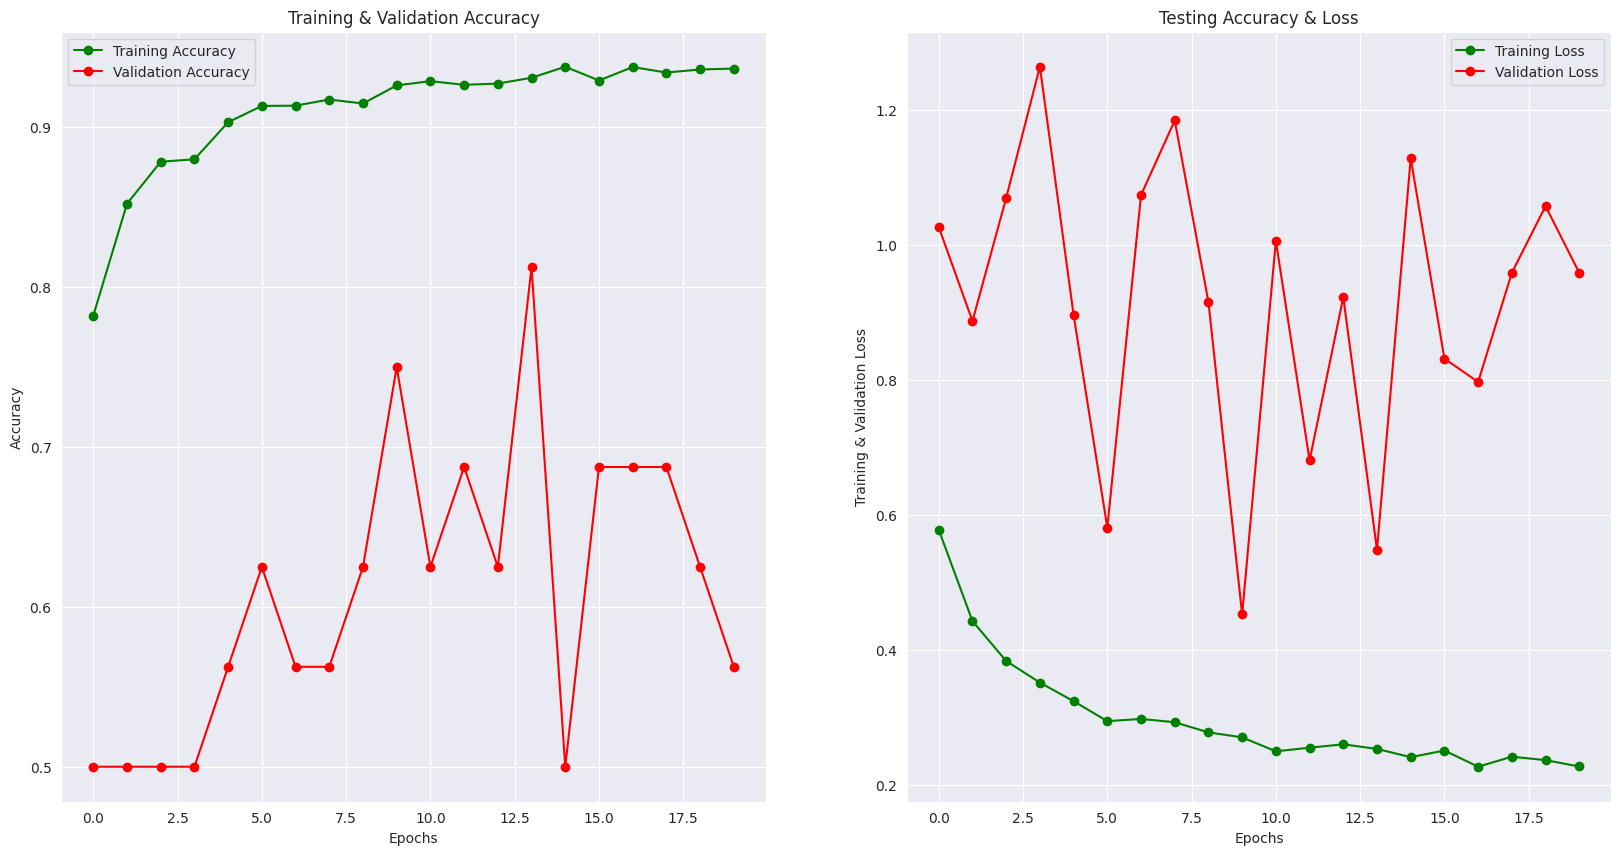

In [29]:
epochs = [i for i in range(len(train_acc))]
fig , ax = plt.subplots(1,2)
train_acc = history_cnn.history['accuracy']
train_loss = history_cnn.history['loss']
val_acc = history_cnn.history['val_accuracy']
val_loss = history_cnn.history['val_loss']
fig.set_size_inches(20,10)
epochs = [i for i in range(len(train_acc))]
ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [38]:
predictions = history_cnn.model.predict(x_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary class labels
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [39]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.89      0.91       390
   Normal (Class 1)       0.83      0.87      0.85       234

           accuracy                           0.88       624
          macro avg       0.88      0.88      0.88       624
       weighted avg       0.89      0.88      0.89       624



In [40]:
cm = confusion_matrix(y_test,predictions)
cm

array([[349,  41],
       [ 31, 203]])

In [41]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

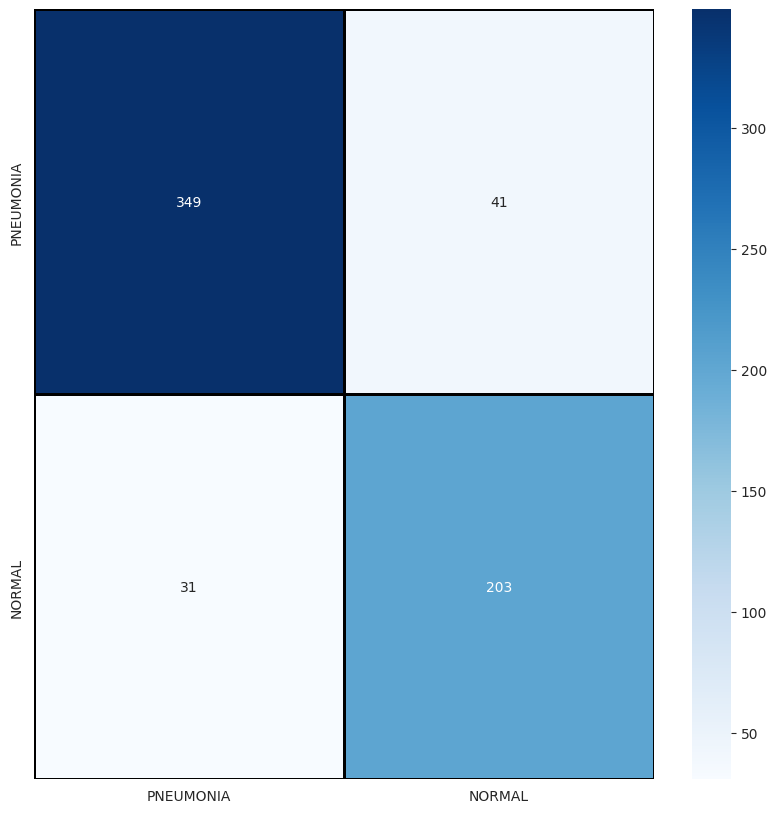

In [42]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

## ResNet

In [50]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [45]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10
input_shape = (150, 150, 1)
num_classes = 1

In [51]:
def block(x, filters, strides=1):
    identity = x
    x = Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides != 1 or identity.shape[-1] != filters:
        identity = Conv2D(filters, 1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x += identity
    x = Activation('relu')(x)
    return x
def create_resnet():
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = block(x, 64)
    x = block(x, 64)
    x = block(x, 64)

    x = block(x, 128, 2)
    x = block(x, 128)
    x = block(x, 128)
    x = block(x, 128)

    x = block(x, 256, 2)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)

    x = block(x, 512, 2)
    x = block(x, 512)
    x = block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model


In [54]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ]
    )
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        epochs=num_epochs,
        validation_data=datagen.flow(x_val, y_val),
        callbacks=[ModelCheckpoint(os.path.join("files", "model.keras"), monitor='val_loss', verbose=1, save_best_only=True)]
    )
    return history

In [55]:
resnet = create_resnet()
history_resnet = run_experiment(resnet)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8401 - auc: 0.8927 - loss: 0.3713
Epoch 1: val_loss improved from inf to 3.69585, saving model to files/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 160ms/step - accuracy: 0.8403 - auc: 0.8929 - loss: 0.3708 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 3.6958
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9110 - auc: 0.9621 - loss: 0.2230
Epoch 2: val_loss improved from 3.69585 to 3.04782, saving model to files/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9111 - auc: 0.9622 - loss: 0.2229 - val_accuracy: 0.5000 - val_auc: 0.5156 - val_loss: 3.0478
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9380 - auc: 0.9780 - loss: 0.1588
Epoch 3: val_loss improved from 3.04782 to 3.04494, saving model to files/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9380 - auc: 0.9780 - loss: 0.1589 - val_accuracy: 0.5000 - val_auc: 0.6016 - v

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ]
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        epochs=50,                                  # train longer, but early-stop
        validation_data=datagen.flow(x_val, y_val),
        callbacks=callbacks
    )

    return history

resnet = create_resnet()
history_resnet = run_experiment(resnet)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 152ms/step - accuracy: 0.8111 - auc: 0.8879 - loss: 0.4010 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 4.3076 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9137 - auc: 0.9623 - loss: 0.2223 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 4.3779 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9325 - auc: 0.9762 - loss: 0.1728 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 4.2107 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9379 - auc: 0.9785 - loss: 0.1592 - val_accuracy: 0.5000 - val_auc: 0.6250 - val_loss: 3.1156 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.9436 - auc: 0.9813 - loss: 0.1532 - val_accuracy: 0.6250 - val_auc: 0.8906 - val_loss: 0.8345 - learning_rate: 1.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 1

### Analysis after Model Training

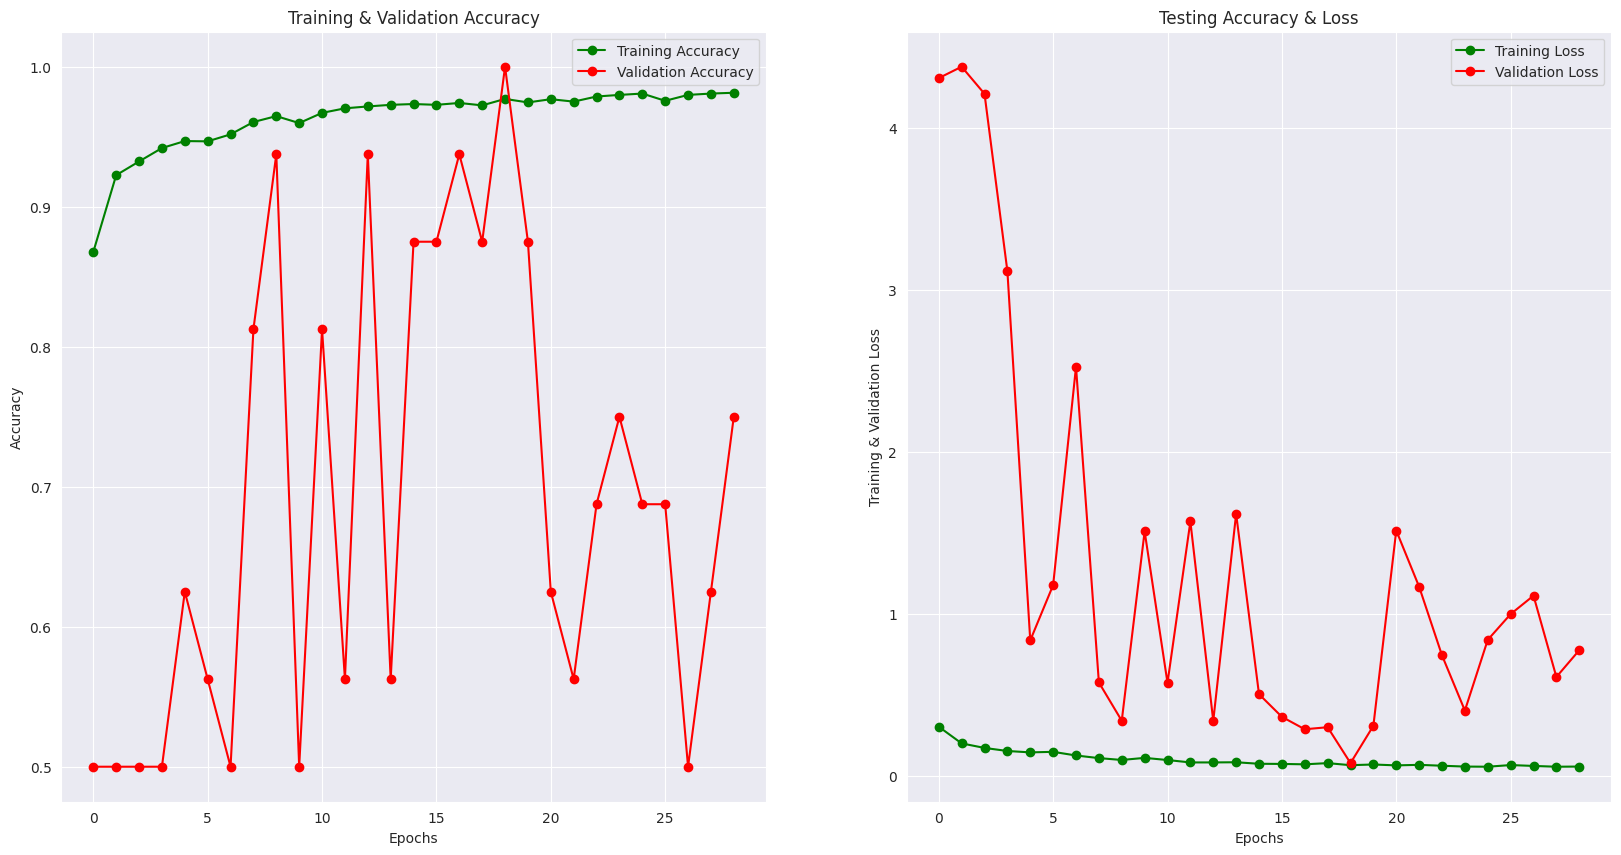

In [59]:
epochs = [i for i in range(len(train_acc))]
fig , ax = plt.subplots(1,2)
train_acc = history_resnet.history['accuracy']
train_loss = history_resnet.history['loss']
val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']
fig.set_size_inches(20,10)
epochs = [i for i in range(len(train_acc))]
ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [65]:
predictions = history_resnet.model.predict(x_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary class labels
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [66]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.87      0.91       390
   Normal (Class 1)       0.81      0.94      0.87       234

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [67]:
cm = confusion_matrix(y_test,predictions)
cm

array([[339,  51],
       [ 14, 220]])

In [68]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

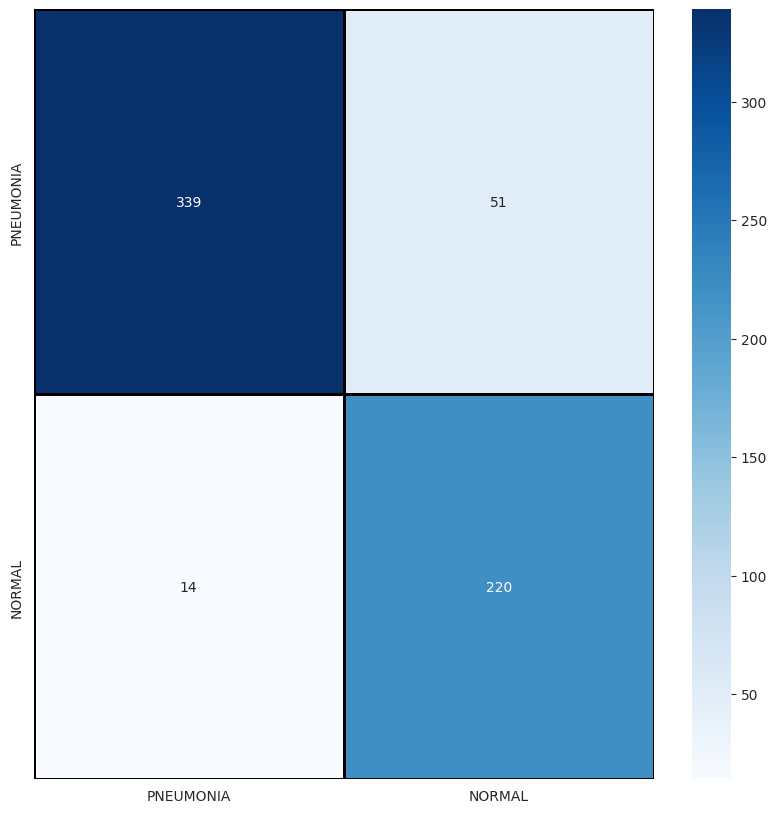

In [69]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

## Transformers

In [70]:
import glob
import os
import random
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

warnings.filterwarnings('ignore')

In [71]:
def mlp(x, hidden_units, dropout_rate, regularizer_rate=0.01):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu, kernel_regularizer=l2(regularizer_rate))(x)
        x = Dropout(dropout_rate)(x)
    return x

In [72]:
from tensorflow.keras import layers

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config

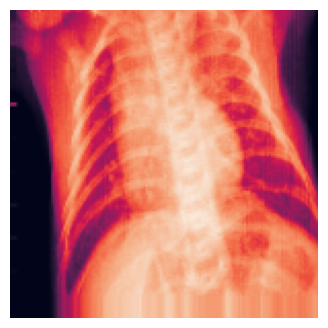

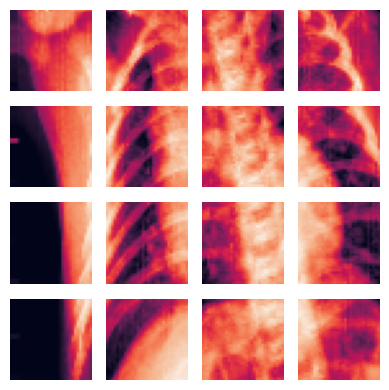

In [91]:
train_generator = datagen.flow(x_train, y_train, batch_size=32)


for image_batch, label_batch in train_generator:
    image = image_batch[0]
    break

image_size = 150
patch_size = 32
num_patches = (image_size // patch_size) ** 2

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

image_tensor = tf.expand_dims(image, 0)

patches_layer = Patches(patch_size)
patches = patches_layer(image_tensor)

patches_numpy = patches.numpy()
if np.max(patches_numpy) <= 1.0:
    patches_numpy *= 255
patches_numpy = patches_numpy.astype('uint8')

n = int(np.sqrt(num_patches))
plt.figure(figsize=(4, 4))
for i in range(n * n):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patches_numpy[0, i].reshape(patch_size, patch_size, 1)
    plt.imshow(patch_img)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [101]:
import tensorflow as tf
from tensorflow.keras import layers

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        # replace ops.arange + ops.expand_dims with tf.range + tf.expand_dims
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = tf.expand_dims(positions, axis=0)
        projected = self.projection(patches)
        return projected + self.position_embedding(positions)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config


In [102]:
num_patches = (image_size // patch_size) ** 2
projection_dim = 64

patch_encoder = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)

encoded_patches = patch_encoder(patches)

input_shape = (150, 150, 1)
patch_size = 32
num_patches = (150 // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]
num_classes = 1
test_datagen = ImageDataGenerator(rescale=1./255)

In [107]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 20

In [108]:
# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=False,
)

# Choose an optimizer
optimizers = {
    "adam": keras.optimizers.Adam(learning_rate=learning_rate),
    "adamw": keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
    "sgd": keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=weight_decay),
    "sgd_momentum": keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
    "adagrad": keras.optimizers.Adagrad(learning_rate=learning_rate),
    "rmsprop": keras.optimizers.RMSprop(learning_rate=learning_rate)
}

optimizer = optimizers["adamw"]
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [109]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Add, Dropout, Flatten

def create_vit_classifier():
    inputs = Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, transformer_units, dropout_rate=0.1, regularizer_rate=0.01)
        encoded_patches = Add()([x3, x2])
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    features = mlp(representation, mlp_head_units, dropout_rate=0.5, regularizer_rate=0.01)
    logits = Dense(num_classes, activation='sigmoid')(features)
    model = Model(inputs=inputs, outputs=logits)
    return model
def run_experiment(model):
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ]
    )

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=datagen.flow(x_val, y_val),
        callbacks=[ModelCheckpoint(os.path.join("files", "model.keras"), monitor='val_loss', verbose=1, save_best_only=True),
                   early_stopping_callback, lr_scheduler],
    )


    return history
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7210 - auc: 0.5586 - loss: 37.9268
Epoch 1: val_loss improved from inf to 28.71942, saving model to files/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 101ms/step - accuracy: 0.7211 - auc: 0.5591 - loss: 37.9063 - val_accuracy: 0.5625 - val_auc: 0.6641 - val_loss: 28.7194 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7808 - auc: 0.8067 - loss: 26.0556
Epoch 2: val_loss improved from 28.71942 to 20.42923, saving model to files/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.7809 - auc: 0.8069 - loss: 26.0427 - val_accuracy: 0.5625 - val_auc: 0.7500 - val_loss: 20.4292 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8363 - auc: 0.8829 - loss: 18.5926
Epoch 3: val_loss improved from 20.42923 to 15.32760, saving model to files/model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8364 - auc: 0.8